In [8]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Apply consistent plot settings
sns.set_style("darkgrid")
sns.set_palette("bright")
plt.rcParams.update({
    "figure.figsize": (8,8),
    "font.size": 8,                    
    "axes.edgecolor": "#DDDDDD",       
    "font.family": "JetBrains Mono",    
    "axes.titlepad": 20,           
    "axes.labelpad": 20,           
    "xtick.major.pad": 8,
    "ytick.major.pad": 8,
    "figure.titlesize": 26,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.color": "#555555"
})



In [9]:
# Load and combine all CSV files ===
file_pattern = "experimental_data/cell_survival_experiments*.csv"
all_files = glob.glob(file_pattern)

df_list = [pd.read_csv(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
print(f"Loaded {len(df)} rows from {len(all_files)} files.")
# Show the first few rows
df.head()

Loaded 10 rows from 1 files.


,Experiment,Tissue Type,Sampled Alpha,Sampled Beta,Fitted Alpha,Fitted Beta,Counting Noise,Cell Count,Dose Error (%),A/B Variation,Alpha Std Dev,B Std Dev,OER,R² - Relative to Fit,MSE - Relative to Fit,R² - Relative to Theoretical Curve,MSE - Relative Theoretical Curve
0,1,Liver,0.050164,0.003,0.051050,0.002912,True,1000,1.5,True,0.0159,0.0,1.0,0.996924,0.000283,0.978532,0.001973
1,2,Liver,0.017661,0.003,0.018668,0.002929,True,1000,1.5,True,0.0159,0.0,1.0,0.995785,0.000419,0.941186,0.005848
2,3,Liver,0.042184,0.003,0.040921,0.003064,True,1000,1.5,True,0.0159,0.0,1.0,0.995481,0.000441,0.993482,0.000636
3,4,Liver,0.030957,0.003,0.031297,0.002976,True,1000,1.5,True,0.0159,0.0,1.0,0.995195,0.000474,0.991003,0.000888
4,5,Liver,0.049446,0.003,0.048006,0.003081,True,1000,1.5,True,0.0159,0.0,1.0,0.995550,0.000422,0.980197,0.001878


In [10]:
tissue_parameters = {
    "Bladder":      {"alpha": 0.044, "beta": 0.003},
    "Breast":       {"alpha": 0.103, "beta": 0.026},
    "Cervix":       {"alpha": 0.130, "beta": 0.003},
    "CNS":          {"alpha": 0.081, "beta": 0.014},
    "Head and Neck":{"alpha": 0.059, "beta": 0.003},
    "Liver":        {"alpha": 0.037, "beta": 0.003},
    "Oesophagus":   {"alpha": 0.04,  "beta": 0.008},
    "Prostate":     {"alpha": 0.067, "beta": 0.024},
    "Rectum":       {"alpha": 0.313, "beta": 0.050},
    "Skin":         {"alpha": 0.005, "beta": 0.009},
    "Custom":       {"alpha": None,  "beta": None}
}

# Map theoretical values in dataframe
df["Theoretical Alpha"] = df["Tissue Type"].map(lambda x: tissue_parameters[x]["alpha"])
df["Theoretical Beta"] = df["Tissue Type"].map(lambda x: tissue_parameters[x]["beta"])

In [11]:
# Work out the raw error of the fitted line to the theoretical
df["Alpha Error"] = df["Fitted Alpha"] - df["Theoretical Alpha"]
df["Beta Error"] = df["Fitted Beta"] - df["Theoretical Beta"]

# Work out the % error of the fitted line to the theoretical
df["% Alpha Error"] = 100 * df["Alpha Error"] / df["Theoretical Alpha"]
df["% Beta Error"] = 100 * df["Beta Error"] / df["Theoretical Beta"]

df.to_csv("./AnalysisResults.csv")

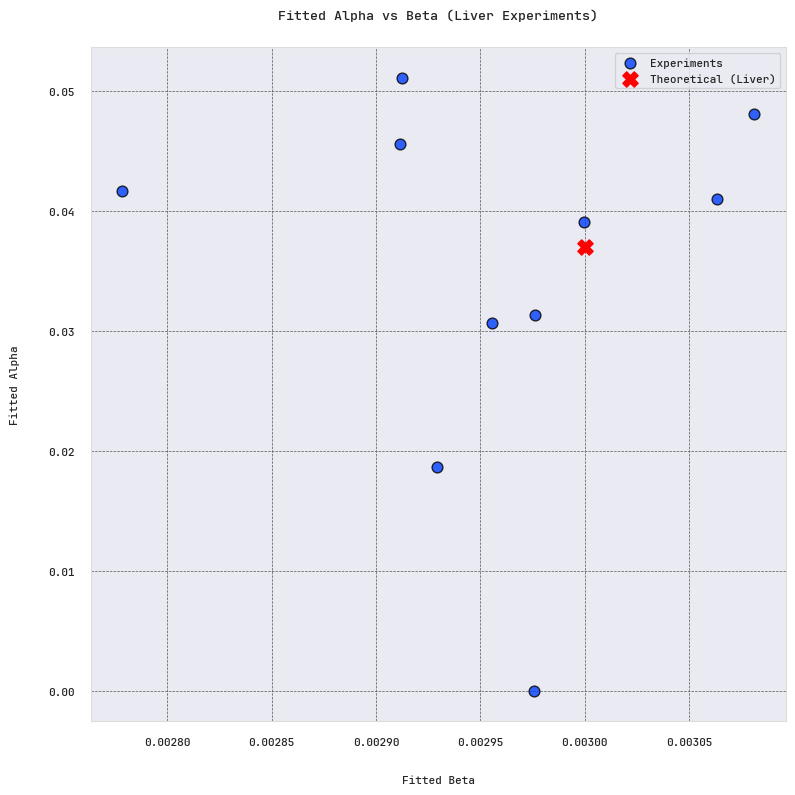

In [12]:
plt.figure(figsize=(8,8))

# Plot per-experiment fitted values
plt.scatter(
    df["Fitted Beta"],
    df["Fitted Alpha"],
    s=60,
    edgecolor="black",
    alpha=0.8,
    label="Experiments"
)

# Plot the single theoretical value for Liver
theoretical_alpha = tissue_parameters["Liver"]["alpha"]
theoretical_beta = tissue_parameters["Liver"]["beta"]

plt.scatter(
    theoretical_beta,
    theoretical_alpha,
    color="red",
    marker="X",
    s=120,
    label="Theoretical (Liver)"
)

plt.xlabel("Fitted Beta")
plt.ylabel("Fitted Alpha")
plt.title("Fitted Alpha vs Beta (Liver Experiments)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/Fitted_Alpha_vs_Beta_Liver.png", bbox_inches='tight')
plt.show()


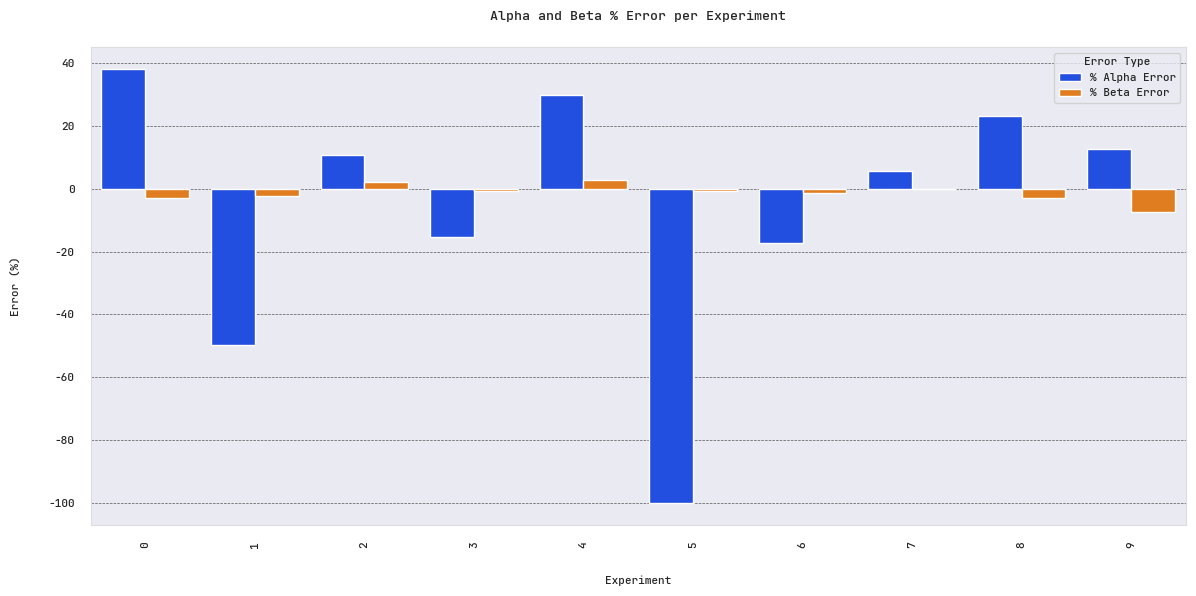

In [13]:
 # Bar chart: % Alpha and Beta Error per Experiment

# Create a new DataFrame with just experiment index and errors
error_df = df[["% Alpha Error", "% Beta Error"]].copy()
error_df["Experiment"] = df.index.astype(str)  # Convert index to string for labeling

# Melt the DataFrame to long format for seaborn barplot
error_long = error_df.melt(id_vars="Experiment", var_name="Error Type", value_name="Error (%)")

plt.figure(figsize=(12, 6))
sns.barplot(data=error_long, x="Experiment", y="Error (%)", hue="Error Type")

plt.title("Alpha and Beta % Error per Experiment")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("figures/Error_Per_Experiment.png", bbox_inches='tight')
plt.show()


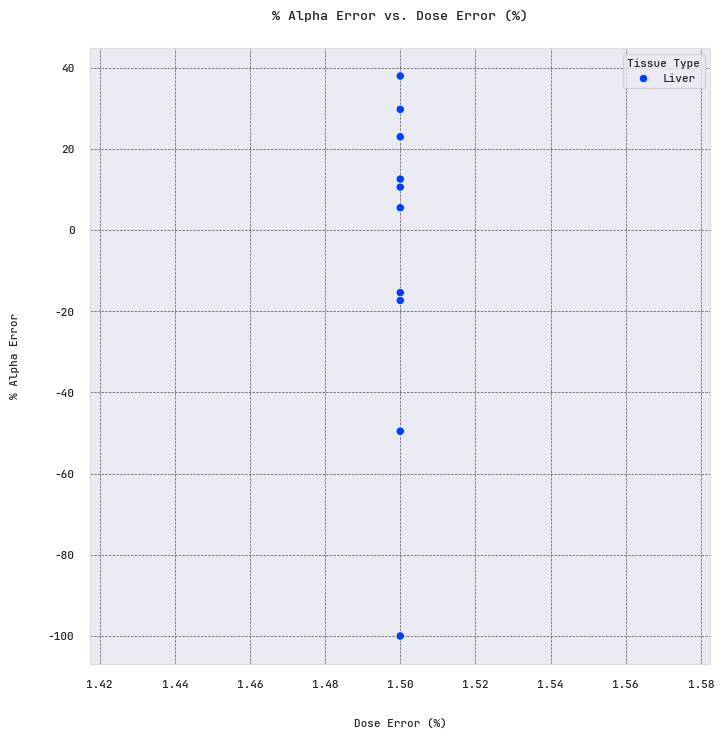

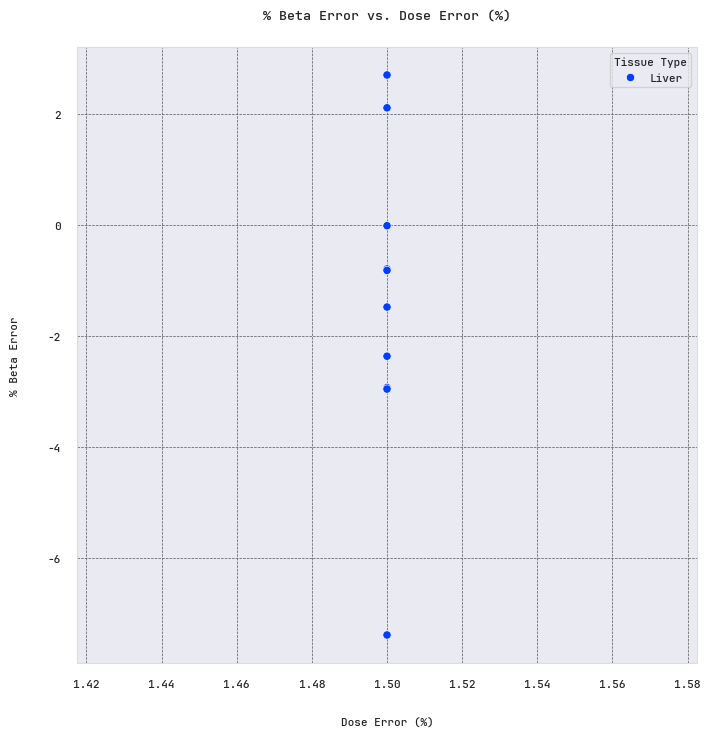

In [14]:
# Alpha Error vs Dose Error
sns.scatterplot(data=df, x="Dose Error (%)", y="% Alpha Error", hue="Tissue Type")
plt.title("% Alpha Error vs. Dose Error (%)")
plt.savefig('figures/Alpha_vs_Dose.png', bbox_inches='tight')
plt.show()

# Beta Error vs Dose Error
sns.scatterplot(data=df, x="Dose Error (%)", y="% Beta Error", hue="Tissue Type")
plt.title("% Beta Error vs. Dose Error (%)")
plt.savefig('figures/Alpha_vs_Dose.png', bbox_inches='tight')
plt.show()

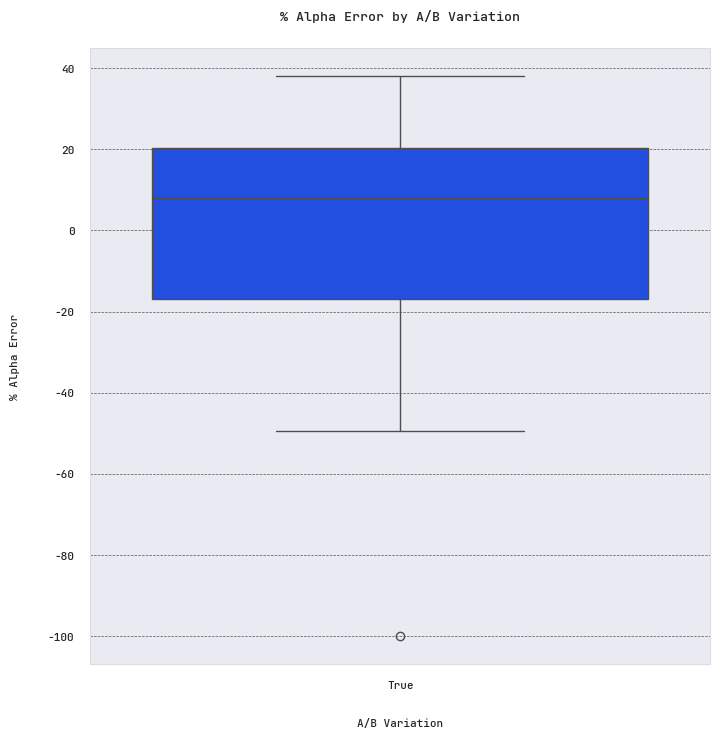

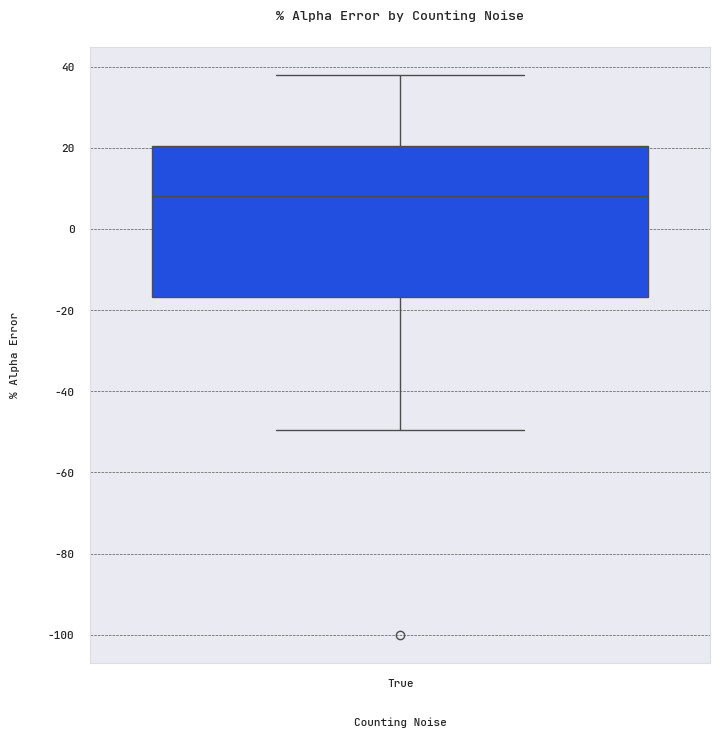

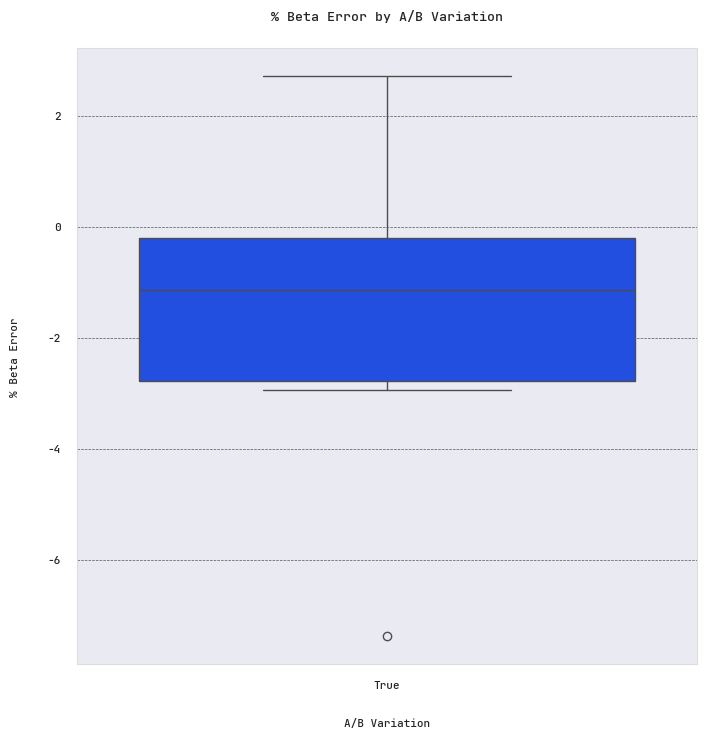

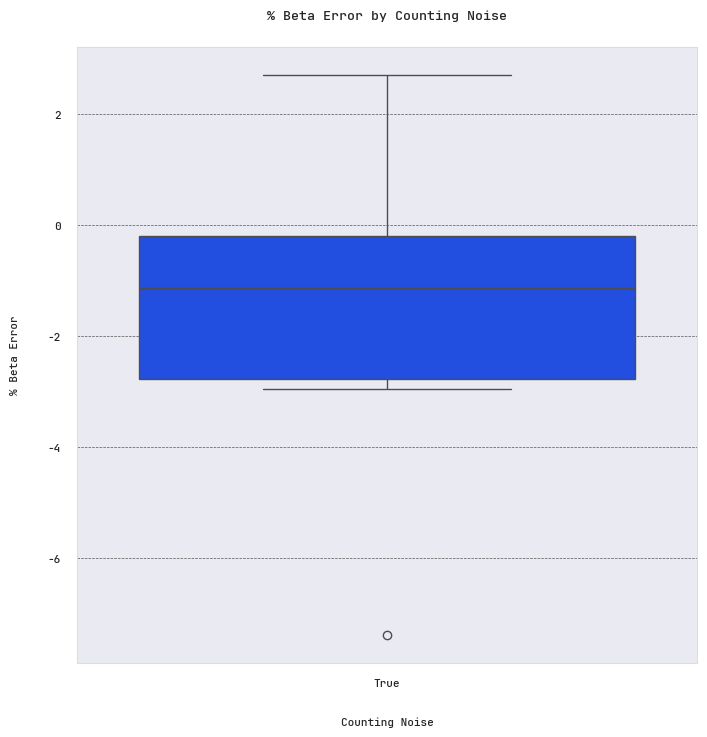

In [15]:
sns.boxplot(data=df, x="A/B Variation", y="% Alpha Error")
plt.title("% Alpha Error by A/B Variation")
plt.savefig('figures/Alpha_vs_ABvar.png', bbox_inches='tight')
plt.show()

sns.boxplot(data=df, x="Counting Noise", y="% Alpha Error")
plt.title("% Alpha Error by Counting Noise")
plt.savefig('figures/Alpha_vs_Count.png', bbox_inches='tight')
plt.show()

sns.boxplot(data=df, x="A/B Variation", y="% Beta Error")
plt.title("% Beta Error by A/B Variation")
plt.savefig('figures/Beta_vs_ABvar.png', bbox_inches='tight')
plt.show()

sns.boxplot(data=df, x="Counting Noise", y="% Beta Error")
plt.title("% Beta Error by Counting Noise")
plt.savefig('figures/Beta_vs_Count.png', bbox_inches='tight')
plt.show()

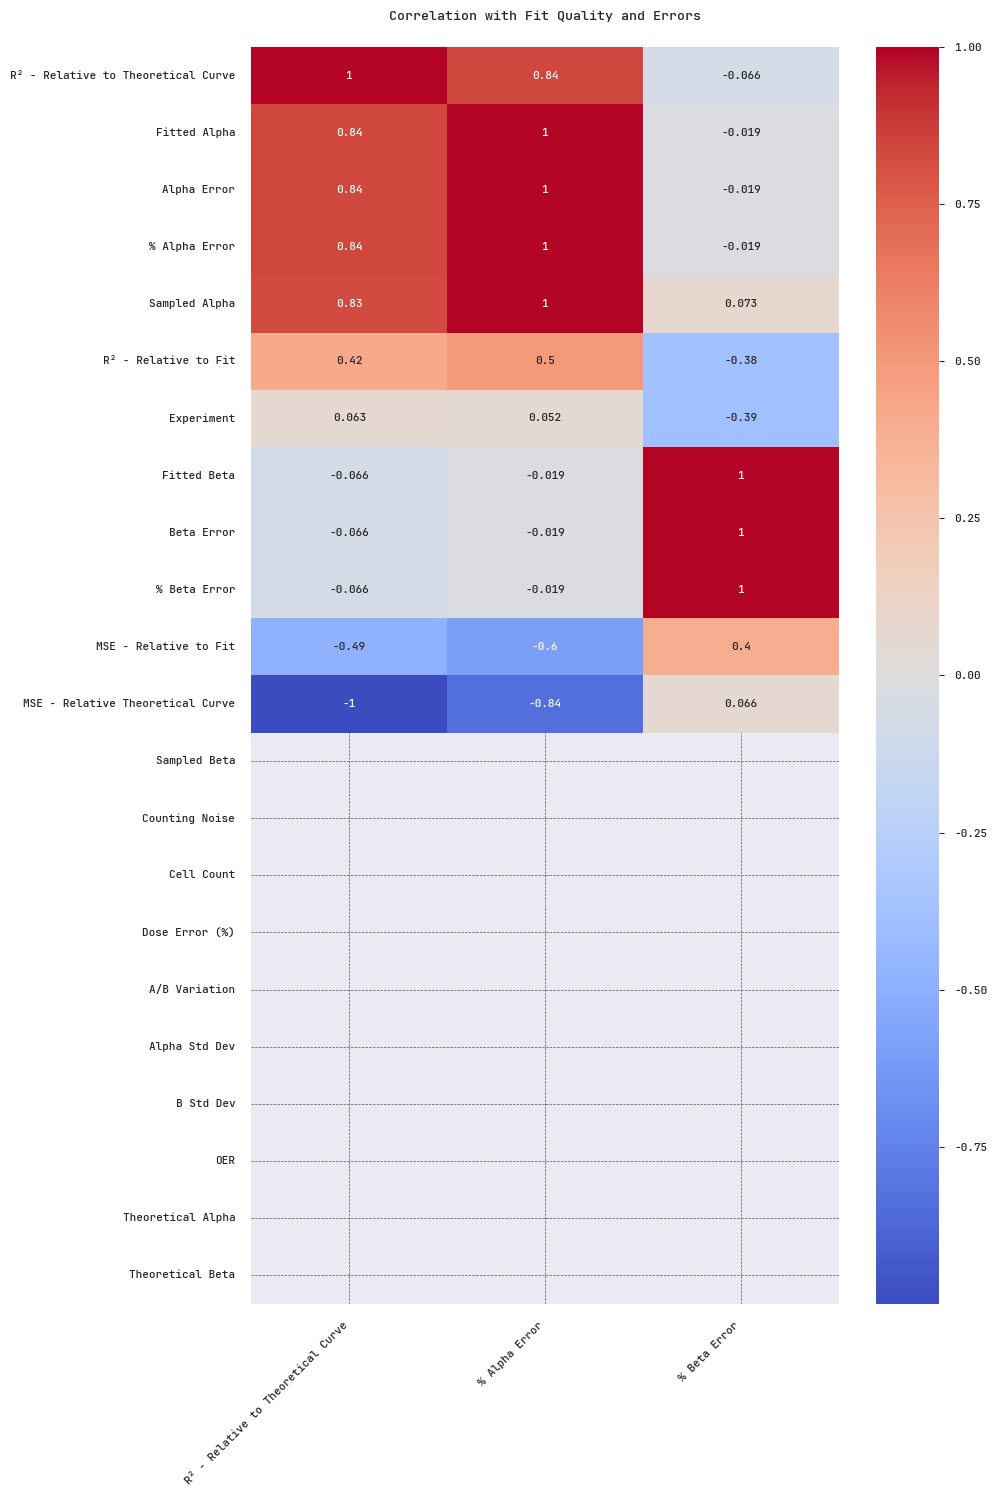

In [16]:
# Correlate variables in heatmap
correlation = df.corr(numeric_only=True)
plt.figure(figsize=(10,15))
sns.heatmap(correlation[["R² - Relative to Theoretical Curve", "% Alpha Error", "% Beta Error"]].sort_values(by="R² - Relative to Theoretical Curve", ascending=False), annot=True, cmap="coolwarm",)
plt.title("Correlation with Fit Quality and Errors")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()  # Prevent squashing
plt.savefig('figures/Heatplot.png', bbox_inches='tight')

plt.show()

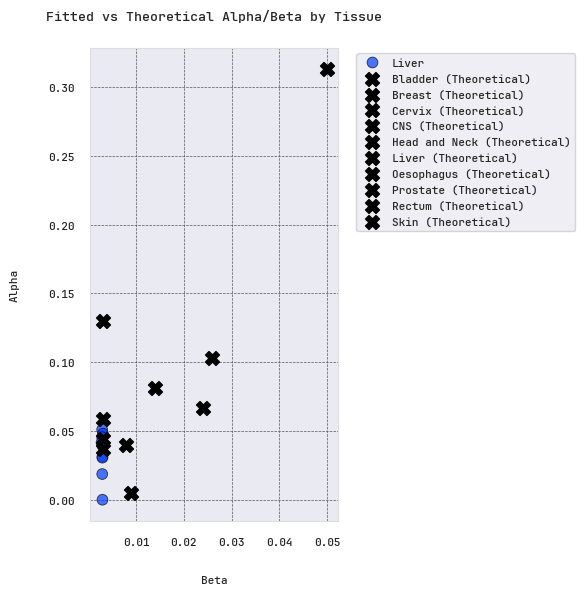

In [17]:
# %%
# Scatter plot of Fitted Alpha vs Fitted Beta, colored by Tissue Type
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x="Fitted Beta", y="Fitted Alpha", hue="Tissue Type", s=60, edgecolor="black", alpha=0.7)

# Overlay theoretical values
for tissue, params in tissue_parameters.items():
    if params["alpha"] is not None and params["beta"] is not None:
        plt.scatter(params["beta"], params["alpha"], color="black", marker="X", s=100, label=f"{tissue} (Theoretical)")

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), bbox_to_anchor=(1.05, 1), loc='upper left',)

plt.xlabel("Beta")
plt.ylabel("Alpha")
plt.title("Fitted vs Theoretical Alpha/Beta by Tissue")
plt.tight_layout()
plt.savefig("figures/Fitted_vs_Theoretical_AlphaBeta.png", bbox_inches='tight')
plt.show()
